## Most relevant Brazilian benchmark assets Principal Component Analysis ##

Paulo Yoshio Kuga

**Abstract**

In this notebook, it is presented a Principal Component Analysis (PCA) of the most relevant Brazilian benchmark assets, such as DI (Interest Rate Futures), US Dollar Futures, and the IBOVESPA index. The Principal Component Analysis is a method to identify orthogonal directions (principal components) of maximum variance in the data, providing an eigenvector matrix that highlight correlations between the benchmarks. It is concluded that, even the correlation being a time-variable future, PCA can show relations between the benchmarks.

First we import our libraries:

In [1]:
import pandas as pd
import numpy as np

import bandeirante as bd
import datetime as dt

from matplotlib import pyplot as plt

import MetaTrader5 as mt5

from hmmlearn.hmm import GaussianHMM

from sklearn.decomposition import PCA

Then we can select a window to be working on. In this notebook, we are using MetaTrader data, which can connect directly to the B3 ecosystem. Bandeirante library have the MQLData class to allow the data to be translated to a pandas object.

In [2]:
end = dt.datetime.today()#(2024,1,18)

start = end-dt.timedelta(days=365*5+1)

mt5_data_getter = bd.MQLData()

DI1_data = mt5_data_getter.get_data("DI1$",start,end,mt5.TIMEFRAME_D1)
DOL_data = mt5_data_getter.get_data("DOL$",start,end,mt5.TIMEFRAME_D1)
IBOV_data = mt5_data_getter.get_data("IBOV",start,end,mt5.TIMEFRAME_D1)

Then, it is possible to select the close fields (the final price on a day) for all the benchmarks. 

We can plot them, observing that they are not stationary, neither are in the same scale. To stabilize them, we can use log-returns, which are a known and useful tool to stabilize financial series.

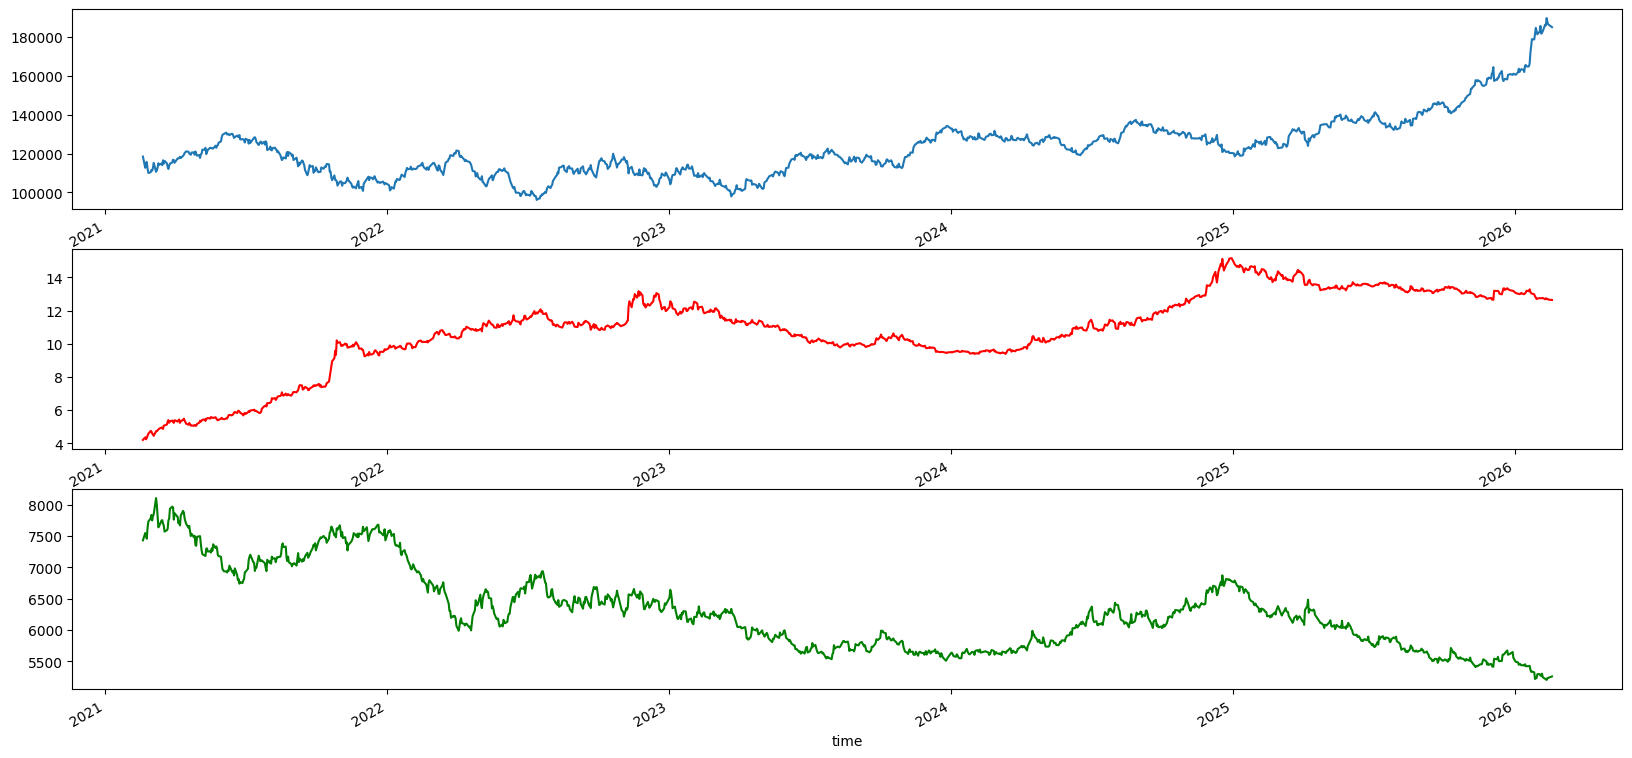

In [3]:
close_data = pd.DataFrame([
    (DI1_data["close"]),
    (DOL_data["close"]),
    IBOV_data["close"]
    ],index=["DI","DOL","IBOV"]
    ).T

fig,axs = plt.subplots(3,1,figsize=(20,10))

close_data["IBOV"].plot(ax=axs[0])
(close_data["DI"]).plot(ax=axs[1],color="red")
(close_data["DOL"]).plot(ax=axs[2],color="green")


cdata_pct = close_data.pct_change().apply(np.log1p)
#cdata_pct["IBOV"] = -cdata_pct["IBOV"]

It is possible to plot the returns and notice that is difficult to have a insight just looking through the time series. 

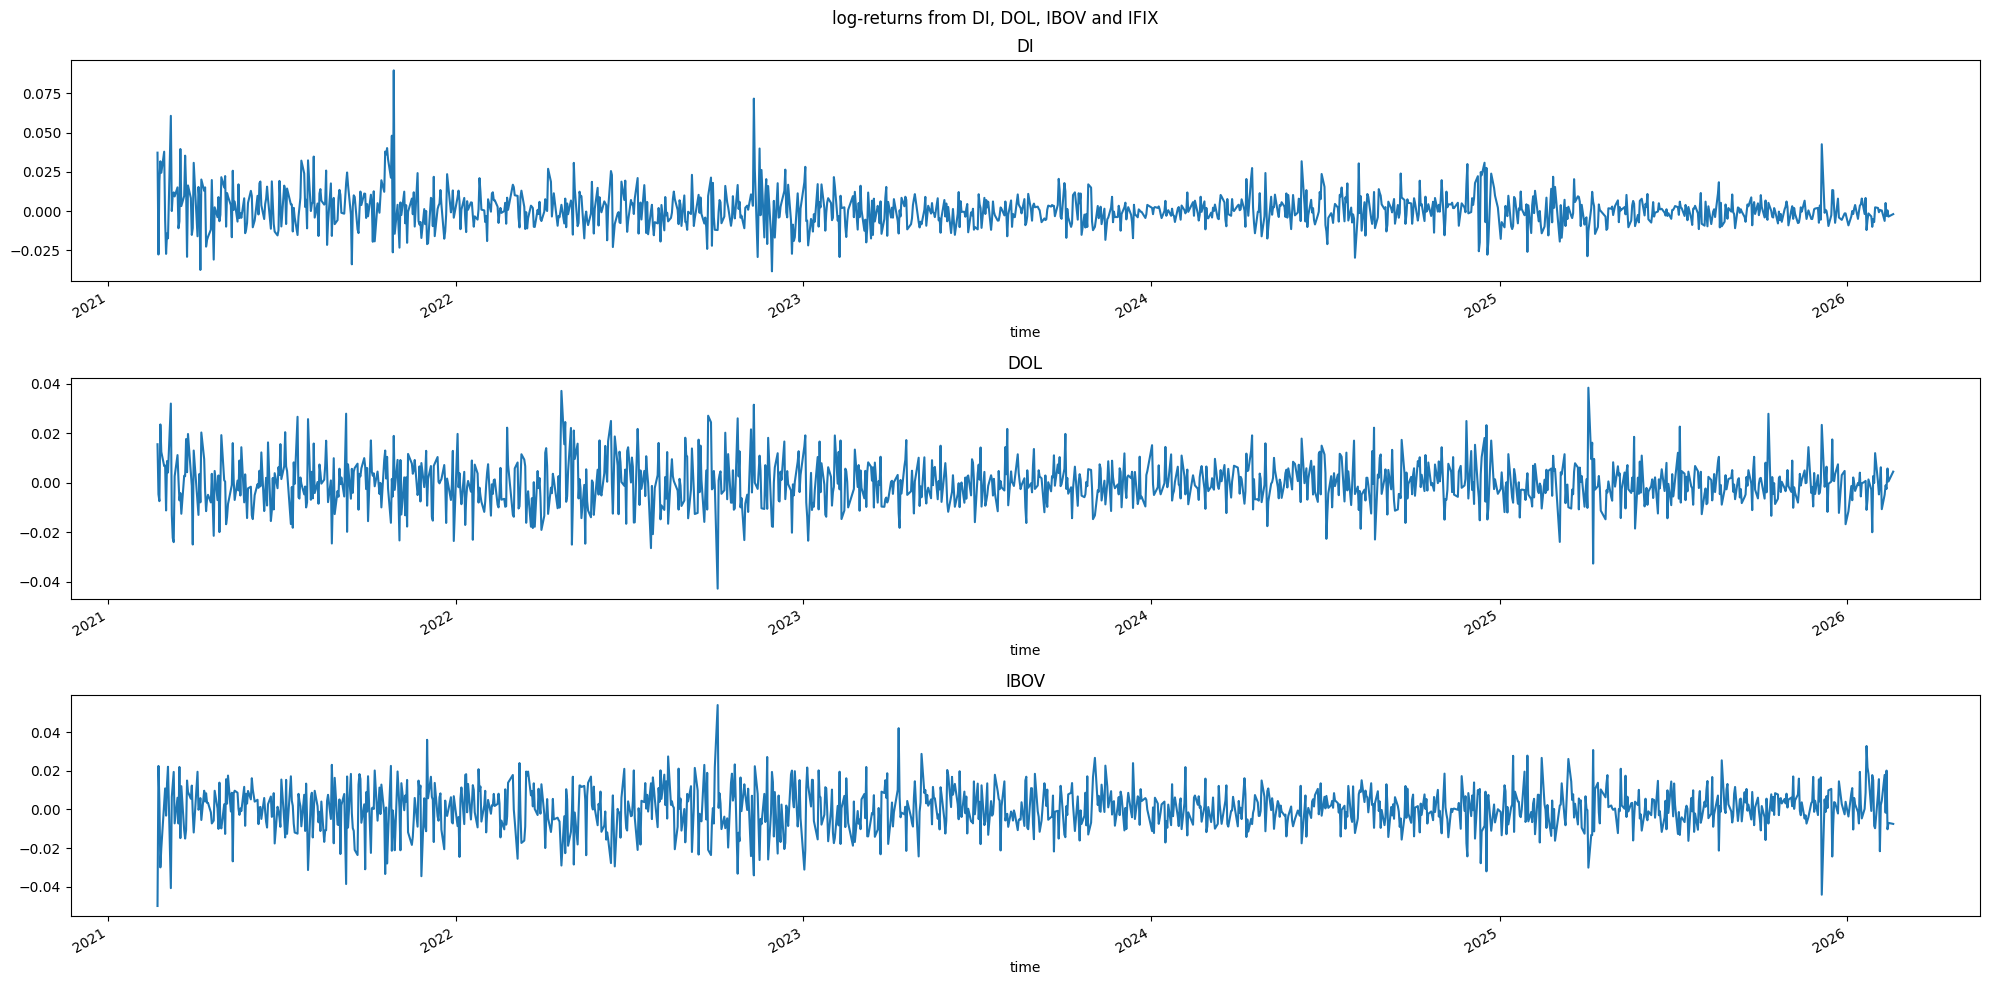

In [4]:
fig, axs = plt.subplots(3,1,figsize=(20,10))
fig.suptitle("log-returns from DI, DOL, IBOV and IFIX")
axs_r = axs.ravel()
for index,column in enumerate(cdata_pct.columns):
    cdata_pct[column].plot(ax=axs_r[index])
    axs_r[index].set_title(column)

fig.tight_layout()

As a non stationary and almost "random" time series, it is not expected that the correlation property is a fixed measure. Due to the nature of data, correlation is time dependent, not being constant over the time. With a 21 days rolling window, we can notice that correlation of DOL and DI with IBOV have a range of -0.8 and 0.4 

Text(0.5, 1.0, 'DOL and DI correlation with IBOV')

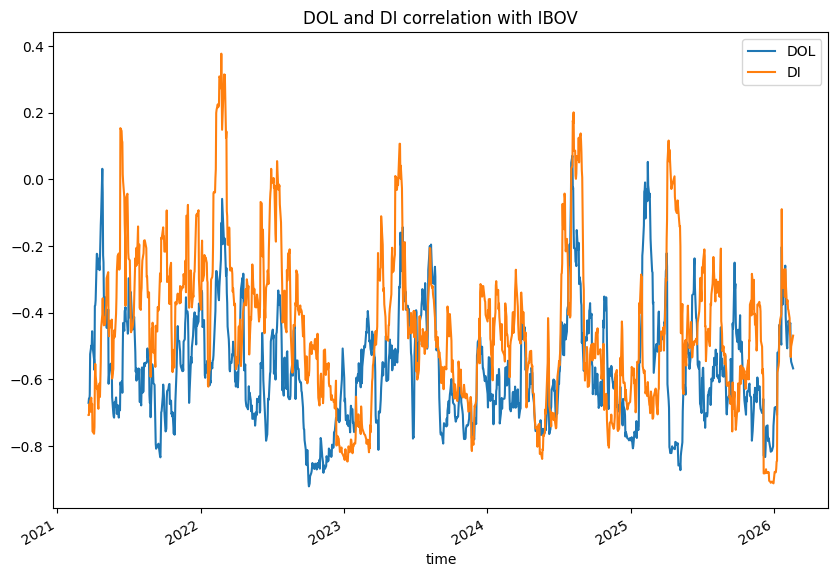

In [5]:
correlation_with_ifix = cdata_pct[["DOL","DI"]].rolling(21).corr(cdata_pct["IBOV"])
correlation_with_ifix.plot(figsize=(10,7))
plt.title("DOL and DI correlation with IBOV")

Next, to train our PCA model, we can adapt our data, filtering the log time series using a low-pass filter (or exponential weighted average mean - EWM). 

This value was selected by experience, so it is invited to the reader to change the alpha values (a coefficient related to filter intensity) to explore the further results. Different alpha values lead to different frequencies being filtered to the PCA, impacting on the correlation obtained on the result. 

Once our input set, we can fit our data to PCA model. 

DI      0.008433
DOL     0.006611
IBOV    0.008199
dtype: float64

In [42]:
X = (
    cdata_pct
    .ewm(alpha=0.7)
    .mean()
    .dropna()
    )

pca_model = PCA(n_components=3)
pca_model.fit(X)

,n_components,3
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


Essentially, the Principal Components of the PCA are the eigenvectors of a covariance matrix. They can indicate relations between the input targets through its weights. Through analyzing the explained variance ratio (the eigenvalue divided through the sum of eigenvalues), we can understand the percentual amount of variance of each PC. For the the eigenvector weights we are able to infer relations between the inputs.

Firstly, we can calculate the explained variance ratio of each component. It is possible to notice that PC0 is the one with greater variance. Since it represents 65% of the variance, PC0 represents the common movement into the market. 

In [43]:
print(pca_model.explained_variance_ratio_)

[0.65563331 0.23037811 0.11398858]


For the eigenvectors, we can plot the matrix using bandeirante. The library has a function that can plot that components, highlighting positive values as red and negative as blue. 

(<Figure size 1000x600 with 2 Axes>,
 <Axes: title={'center': 'PCA - Measures and Variance Components'}, xlabel='PCA Components', ylabel='Original Data Features'>)

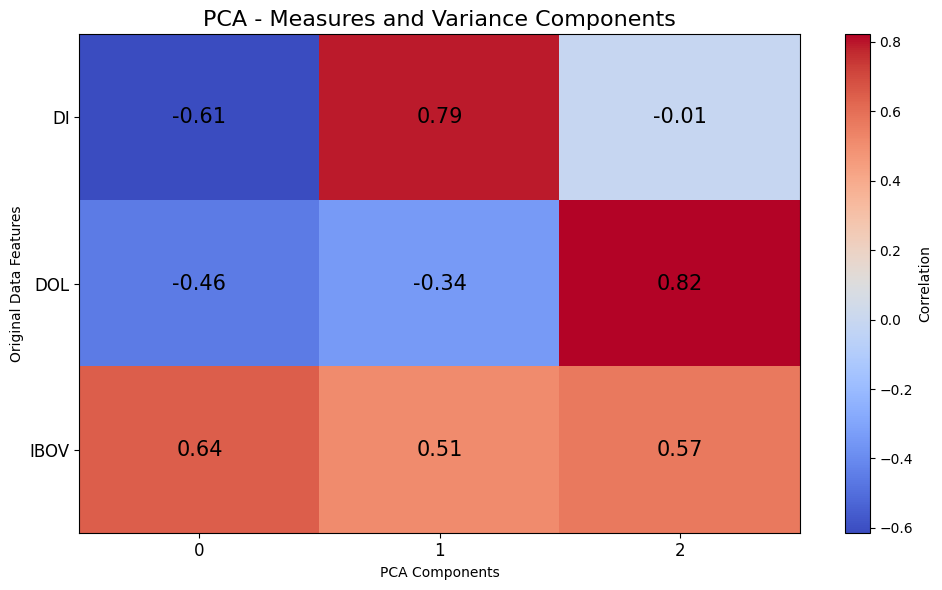

In [50]:
bd.transformation_components_plot(pca_model,close_data.columns,figsize=(10,6),textsize=15,ticksize=12)

We can notice that PC0 is composed by a positive value for IBOV and negative values for DI and DOL. This represents a fact that when IBOV increases, DI and DOL decreases and vice versa. 

However, correlation is not the cause. PC0 point that relation because the fact that when IBOV increases, the flux of dollars are higher, decreasing it price. When DI goes down, the price of IBOV can increase due to the fact that equities gain more opportunity cost against fixed income bonds. But these behaviours are trends, and may not always happen. When in a structural crisis, such as total risk aversion (e.g. WW3), the cost of safe assets, such as gold, silver and other could lead to a decrease into dollar and IBOV prices. 

Later, we can evaluate the returns from each component along the time and the accumulated returns. 

Text(0.5, 1.0, 'Principal Components returns')

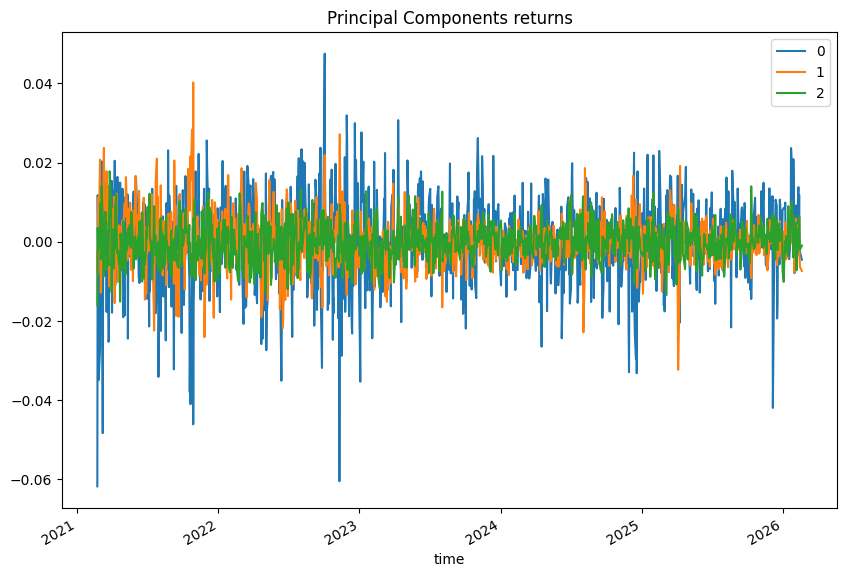

In [52]:
pca_transformed = pd.DataFrame(
    pca_model.fit_transform(X),
    columns=[str(i) for i in range(0,3)],
    index=X.index)

pca_transformed.plot(figsize=(10,7))
plt.title("Principal Components returns")

Text(0.5, 1.0, 'Principal Components of benchmarks along time')

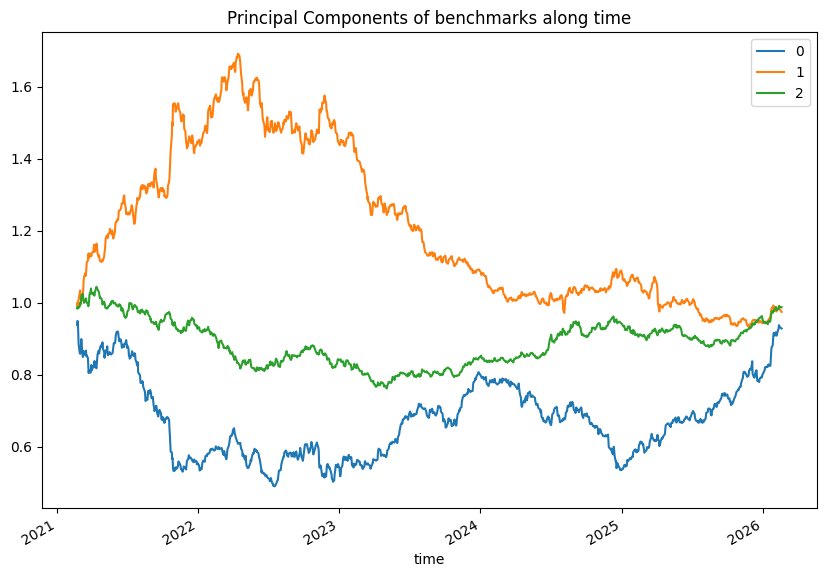

In [53]:
pca_trans_cumprod = pca_transformed.add(1).cumprod()
pca_trans_cumprod.plot(figsize=(10,7))
plt.title("Principal Components of benchmarks along time")


It is possible to notice that, indeed, PC0 has the more volatile beahviour on log return. PC1 and PC2 have less volatility, however the accumulated returns of PC1 have the bigger amplitude in relation to other components, meanwhile PC2 has the lesser. Therefore it is important to notice that even that PCA minimizes log-return variance with the increasing of principal components index, this might not be true on accumulated returns. Therefore, it is not safe to assume that a portifolio composed with the greatest index will be the "safer" one.

With that, we can conclude that PCA is a useful tool to determine whether relations are more evident in the dataset. Even, as shown, correlations are variable in time, the principal components showed relations that are observable and meaningful along the known market movements. Therefore, PCA can be used to provide insights about important market benchmarks.